### Date: 6 April 2017

Aim: The aim of this notebook is to compare two cost functions

In [1]:
import sys

In [2]:
sys.path.append("../code/")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys, traceback
from docopt import docopt
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict, create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, prepare_df_factorisation,prepare_known_features, create_matrix_factorised, create_prediction

In [5]:
from nnmf_tensorflow import factorize as tf_factorize
from nnmf_autograd import factorize as a_factorize

In [6]:
from common_functions import *

In [7]:
year=2014
seed = 0
test_home=26
test_home_list = [test_home]
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['Austin']=1.0
test_region = 'Austin'
feature_list = ['energy','home']
appliance="fridge"
feature_comb = ['None']
lat = 2

In [8]:
preds = {}
errors = {}

In [9]:
df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                test_region, test_home_list,
                                                                                     feature_list, seed, 3000, 0, True)

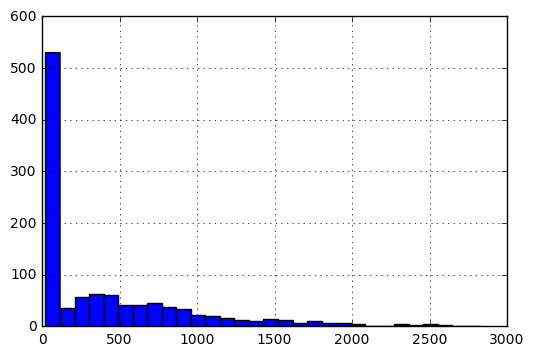

In [19]:
X_matrix.stack().hist(bins=30)

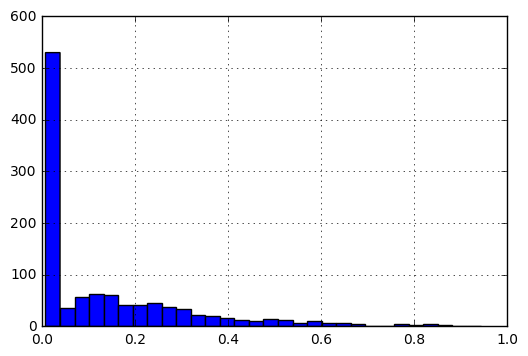

In [20]:
X_normalised.stack().hist(bins=30)

In [18]:

for appliance in ['hvac']:
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                test_region, test_home_list,
                                                                                     feature_list, seed, 3000, 0, True)
    
    homes = X_matrix.index
    
    if appliance not in preds:
        preds[appliance] = {}
        errors[appliance] = {}

    for cost in ['absolute','relative']:
        if cost not in preds[appliance]:
            preds[appliance][cost] = {}
            errors[appliance][cost] = {}
        for lat in range(2, 5):
            if lat in preds[appliance][cost]:
                continue
            print "*"*20
            o = {}
            for home in homes[:]:
                print appliance, cost, lat, home
                A = (X_normalised).copy()
                A.ix[home][appliance_cols] = np.NAN
                W, H = a_factorize(A, lat, lr=0.01, cost_function=cost)
                pred_df = pd.DataFrame(np.dot(W, H))*3000
                pred_df.index = A.index
                pred_df.columns = A.columns
                o[home]=pred_df.ix[home][appliance_cols]
            preds[appliance][cost][lat] = pd.DataFrame(o).T
            
            agg = dfc[aggregate_cols].ix[preds[appliance][cost][lat].index]
            agg.columns = preds[appliance][cost][lat].columns

            gt_appliance = dfc[appliance_cols].ix[preds[appliance][cost][lat].index]

            gt_fraction = 100*(gt_appliance/agg)
            pred_fraction = 100*(preds[appliance][cost][lat]/agg)
            gt_fraction_dropna = gt_fraction.unstack().dropna()
            pred_fraction_dropna = pred_fraction.unstack().dropna()
            pred_fraction_dropna = pred_fraction_dropna.ix[gt_fraction_dropna.index]

            rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
            errors[appliance][cost][lat] = rms
            print(rms)
                
                
              

********************
hvac absolute 2 121
hvac absolute 2 135
hvac absolute 2 222
hvac absolute 2 364
hvac absolute 2 370
hvac absolute 2 410
hvac absolute 2 545
hvac absolute 2 661
hvac absolute 2 871
hvac absolute 2 936
hvac absolute 2 946
hvac absolute 2 1283
hvac absolute 2 1310
hvac absolute 2 1463
hvac absolute 2 1642
hvac absolute 2 1697
hvac absolute 2 1700
hvac absolute 2 1790
hvac absolute 2 1953
hvac absolute 2 2156
hvac absolute 2 2242
hvac absolute 2 2470
hvac absolute 2 2557
hvac absolute 2 2814
hvac absolute 2 3009
hvac absolute 2 3036
hvac absolute 2 3367
hvac absolute 2 3443
hvac absolute 2 3456
hvac absolute 2 3482
hvac absolute 2 3652
hvac absolute 2 3723
hvac absolute 2 3736
hvac absolute 2 3778
hvac absolute 2 3829
hvac absolute 2 3893
hvac absolute 2 3967
hvac absolute 2 4297
hvac absolute 2 4298
hvac absolute 2 4342
hvac absolute 2 4505
hvac absolute 2 4767
hvac absolute 2 4874
hvac absolute 2 4922
hvac absolute 2 4946
hvac absolute 2 4957
hvac absolute 2 4998
hva

In [19]:
errors

{'fridge': {'absolute': {2: 8.2932623258198053,
   3: 9.4748930897798953,
   4: 15.300730816011981},
  'relative': {2: 5.9631028450626005,
   3: 6.2810569838989299,
   4: 5.3580848433525041}},
 'hvac': {'absolute': {2: 21.480501859795169,
   3: 20.651638802027804,
   4: 22.927088851325493},
  'relative': {2: 14.032173417843934,
   3: 14.494250888579527,
   4: 14.749445854964215}}}

In [20]:
pd.DataFrame(errors['hvac'])

,absolute,relative
2,21.480502,14.032173
3,20.651639,14.494251
4,22.927089,14.749446


In [21]:
rank=2
shape = A.shape
H = np.abs(np.random.randn(rank, shape[1]))
W = np.abs(np.random.randn(shape[0], rank))

In [22]:
def cost_abs(W, H):
    pred = np.dot(W, H)
    mask = ~np.isnan(A)
    return np.sqrt(((pred - A)[mask].flatten() ** 2).mean(axis=None))

def cost_rel(W, H):
    pred = np.dot(W, H)
    mask = ~np.isnan(A)
    abs_error = (pred - A)[mask].flatten()
    rel_error = np.divide(abs_error, A[mask].flatten() + 1e-8)
    return np.sqrt((rel_error ** 2).mean(axis=None))

In [23]:
cost_abs(W, H)

1.2883284435617217

In [24]:
cost_rel(W, H)

18.513662053088581

In [25]:
pred = np.dot(W, H)
mask = ~np.isnan(A)

In [27]:
abs_error = (pred - A)[mask].flatten()

In [30]:
np.power(abs_error, 2).mean()

1.6597901784901685

In [31]:
relative_error = np.divide(abs_error, A[mask].flatten() + 1e-8)

In [32]:
relative_error

array([ 0.9205153 ,  6.10773933, -0.29401241, ..., -0.56907172,
       -0.72489415, -0.54105395])

In [ ]:
def f(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None, cost='absolute', use_all=True):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0, use_all)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                        idx_user=idx_user, data_user=data_user,
                         idx_item=idx_item, data_item=data_item, MAX_ITERS=15, cost=cost)
    return X, Y, res, df

In [ ]:
def f_tf(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None, cost='absolute', use_all=True):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0, use_all)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    A = A.astype('float32')
    X, Y = factorize(A, rank=lat, cost_function=cost) 
    
    return X, Y, None, df

In [ ]:
preds = {}
errors ={}

In [ ]:
import time

In [ ]:
pred_df*3000

In [ ]:
pred_df

In [ ]:
X

In [ ]:
Y

In [ ]:
pd.DataFrame(np.dot(Y, X))            

In [ ]:
pd.DataFrame(errors['fridge'])            

In [ ]:
from nnmf_tensorflow import factorize

In [ ]:
appliance="hvac"
df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                test_region, test_home_list,
                                                                                     feature_list, seed, 3000, 0, True)

In [ ]:
appliance

In [ ]:
X_normalised = X_normalised.astype('float32')
W, H = factorize(X_normalised, 2)